# Libraries

In [1]:
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Basic libraries
#
import time
import os
import pickle
import json
from   tqdm   import tqdm
import pandas as pd
import numpy  as np
import time


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Visualization library
#
import matplotlib.pyplot as plt
import seaborn           as sns


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Sklearn library
#
from sklearn.preprocessing import StandardScaler


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Tensorflow library
#
import tensorflow                 as tf
from   tensorflow.keras.callbacks import *
from   tensorflow.keras.metrics   import *
from   tensorflow.keras.layers    import *
from   tensorflow.keras           import Sequential
from   tensorflow.keras           import optimizers


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# User libraries
#
from utils.Logger        import *
from utils.InfuxDBClient import *

# Parameters

In [2]:
# Selected sensor
#
Sensor = '01cc0529-79bb-48cc-a052-4fde9372abeb'

# Set look-back (Lag)
#
Lag = 32

# Set 'verbose'
#
VERBOSE = True

# Initiate logger
#
if VERBOSE:
    logger = init_logger( log_file = 'logs.log' )  

# Data

## Download data from InfuxDB

## Setup InfuxDB Client

In [3]:
influx_measurement = "beat_box_rms"


# Change to influx live data 
#
influx = InfluxDataframeDBClient(host     = '192.168.2.198', 
                                 username = 'admin',
                                 pwd      = 'CoreInn02019', 
                                 port     =  8086, 
                                 db       = 'corebeat_rms')
influx.initClient()

### Download data

In [4]:
# Start timer
#
start_timer = time.time()

# TABLE: corebeat_rms
#
df = influx.client.query(f'SELECT * from {influx_measurement}') 
df = df[ influx_measurement ]
#
if VERBOSE: 
    logger.info('[INFO] Download data from CoreBEAT database')
    logger.info('[INFO] Time: {:.2f}s'.format(time.time() - start_timer))



# Preprocess data
#
df = df[ df['beat_box_id'] == Sensor]

# 
del df['beat_box_id']


if VERBOSE: 
    logger.info('[INFO] Data cleaning - Data processing')
    logger.info('[INFO] Number of features: {}'.format(df.shape[1]))
    
df.head( 3 )

[INFO] Download data from CoreBEAT database
[INFO] Time: 1.43s
[INFO] Data cleaning - Data processing
[INFO] Number of features: 4


,acc_x,acc_y,acc_z,temperature
2022-06-18 02:01:19+00:00,0.238592,0.186857,0.211078,31.8
2022-06-18 02:02:19+00:00,0.186287,0.129006,0.146181,31.8
2022-06-18 02:03:18+00:00,0.187383,0.137613,0.151158,31.9


# Training/Validation/Testing datasets

## Split data

In [5]:
train_idx = int( df.shape[0] * 0.8 )
valid_idx = int( df.shape[0] * 0.9 )


df_train = df[ :train_idx ].copy()
df_valid = df[ train_idx:valid_idx ].copy()
df_test  = df[ valid_idx: ]

## Fix lag

In [6]:
df_valid = pd.concat([df_train.iloc[-Lag:], df_valid])
df_test  = pd.concat([df_valid.iloc[-Lag:], df_test])

## Scaling data

In [7]:
# Set scaler
#
scaler = StandardScaler()

df_train = pd.DataFrame(data    = scaler.fit_transform(df_train),
                        columns = df_train.columns, 
                        index   = df_train.index)

df_valid = pd.DataFrame(data    = scaler.transform(df_valid),
                        columns = df_valid.columns, 
                        index   = df_valid.index)


df_test   = pd.DataFrame(data    = scaler.transform(df_test),
                         columns = df_test.columns, 
                         index   = df_test.index)

# Creating training/validation/testing instances

In [8]:
def create_dataset(df = None, Lag = 1, overlap = 1):
    
    X, Dates = [], []
    for i in tqdm( range( df.shape[0] - Lag ) ):
        X     += [ df[i:i+Lag].to_numpy() ]
        Dates += [ df.index[i+Lag]        ]
    
    return ( np.array(X), np.array(Dates) )

In [9]:
# Training instances
#
trainX, trainDates = create_dataset(df = df_train, Lag = Lag)
if VERBOSE: 
    logger.info('[INFO] Training instances created')

    
# Validation instances
#
validX, validDates = create_dataset(df = df_valid, Lag = Lag)
if VERBOSE: 
    logger.info('[INFO] Validation instances created')
 

# Testing instances
#
testX, testDates   = create_dataset(df = df_test, Lag = Lag)
if VERBOSE: 
    logger.info('[INFO] Testing instances created')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22068/22068 [00:00<00:00, 22276.50it/s]
[INFO] Training instances created
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2763/2763 [00:00<00:00, 22348.94it/s]
[INFO] Validation instances created
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2763/2763 [00:00<00:00, 22190.26it/s]
[INFO] Testing instances created


# Anomaly detection model

## Setup CUDA

In [10]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        
    except RuntimeError as e:
        
        # Memory growth must be set before GPUs have been initialized
        print(e)

## Setup model

In [11]:
# Define metrics
#
metrics = [
            RootMeanSquaredError(name = 'RMSE', dtype = None),
            MeanAbsoluteError(name='MAE', dtype=None)
          ]

2022-07-07 15:54:34.881160: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
   
model = Sequential(
    [
        Input(shape = (trainX.shape[1], trainX.shape[2]), name = 'InputLayer'),
        #
        # Since the problem is semi-supervised - Gaussian noise is applied
        GaussianNoise( stddev = 0.05 ),
        
        # =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
        # Encoder
        #
        Conv1D(filters     = 16, 
               kernel_size = 7, 
               padding     = "same", 
               strides     = 1, 
               activation  = "elu"),
        #
        BatchNormalization(),
        Dropout(0.5),
        #
        MaxPooling1D(pool_size = 2, 
                     padding   = 'same'),
        #
        Conv1D(filters     = 8, 
               kernel_size = 3, 
               padding     = "same", 
               strides     = 1, 
               activation  = "elu"),
        #
        BatchNormalization(),
        Dropout(0.2),
        #        
        MaxPooling1D(2, padding='same'),
        
        
        # =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
        # Decoder
        #
        Conv1D(filters     = 8, 
               kernel_size = 3, 
               padding     = "same", 
               strides     = 1, 
               activation  = "elu"),
        #
        BatchNormalization(),
        #
        UpSampling1D(size = 2),
        #
        Conv1D(filters     = 16, 
               kernel_size = 7, 
               padding     = "same", 
               strides     = 1, 
               activation  = "elu"),
        #
        BatchNormalization(),
        #
        UpSampling1D(size = 2),
        #
        Conv1D(filters     = trainX.shape[2], 
               kernel_size = 3, 
               padding     = "same", 
               strides     = 1, 
               activation  = "linear",
               name        = 'OutputLayer' ),        
    ]
)



# Set loss and optimizer
#
model.compile(optimizer = optimizers.Adam(learning_rate = 1e-4),
              loss      = 'mse',
              metrics   = metrics)

if VERBOSE:
    logger.info('[INFO] Anomaly detection model was setup')

[INFO] Anomaly detection model was setup


In [13]:
print('[INFO] Input layer:  ', model.input.name)
print('[INFO] Output layer: ', model.output.name)

# Model summary
#
model.summary()

[INFO] Input layer:   InputLayer
[INFO] Output layer:  OutputLayer/BiasAdd:0
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise (GaussianNoi  (None, 32, 4)            0         
 se)                                                             
                                                                 
 conv1d (Conv1D)             (None, 32, 16)            464       
                                                                 
 batch_normalization (BatchN  (None, 32, 16)           64        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 32, 16)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 16, 16)           0         
 )                                           

## Setup training parameters

In [14]:
# Set parameters
#
parameters = {'epochs'           : 1000,
              'batch_size'       : 64,
              'verbose'          : True}




# Checkpoint
#
if ( not os.path.isdir('checkpoint') ):
    os.mkdir('checkpoint')
#
checkpoint = ModelCheckpoint("checkpoint/AnomalyDetectionModel.hdf5", 
                             save_weights_only = True,
                             monitor           = 'val_loss', 
                             verbose           = 0, 
                             save_best_only    = True, 
                             mode              = 'min')

# Earlystopping
#
earlystopping = EarlyStopping(monitor       = 'val_loss', 
                              mode          = 'min', 
                              verbose       = 1, 
                              patience      = 20)


# Learning rate adjustment
#
lrs_scheduler  = ReduceLROnPlateau(monitor   = 'val_loss', 
                                   factor    = 0.5,
                                   min_delta = 1.e-6,
                                   patience  = 10)


if VERBOSE:
    logger.info('[INFO] Training process was setup')

[INFO] Training process was setup


## Model training

In [15]:
start_timer = time.time()

score = model.fit(trainX, trainX,
                  epochs           = parameters['epochs'],
                  batch_size       = parameters['batch_size'],                    
                  verbose          = parameters['verbose'],
                  #
                  callbacks        = [checkpoint, earlystopping, lrs_scheduler],
                  #
                  validation_data  = (validX, validX))

if VERBOSE:
    logger.info('[INFO] Model has been successfully trained')
    logger.info('[INFO ] Time: {:.2f}s'.format(time.time() - start_timer))

Epoch 1/1000
345/345 [==============================] - 2s 4ms/step - loss: 1.2830 - RMSE: 1.1327 - MAE: 0.8287 - val_loss: 0.5990 - val_RMSE: 0.7740 - val_MAE: 0.5443 - lr: 1.0000e-04
Epoch 2/1000
345/345 [==============================] - 1s 4ms/step - loss: 0.5769 - RMSE: 0.7595 - MAE: 0.5414 - val_loss: 0.4697 - val_RMSE: 0.6853 - val_MAE: 0.4387 - lr: 1.0000e-04
Epoch 3/1000
345/345 [==============================] - 1s 4ms/step - loss: 0.4849 - RMSE: 0.6964 - MAE: 0.4822 - val_loss: 0.4350 - val_RMSE: 0.6596 - val_MAE: 0.3991 - lr: 1.0000e-04
Epoch 4/1000
345/345 [==============================] - 1s 4ms/step - loss: 0.4448 - RMSE: 0.6670 - MAE: 0.4532 - val_loss: 0.4138 - val_RMSE: 0.6433 - val_MAE: 0.3771 - lr: 1.0000e-04
Epoch 5/1000
345/345 [==============================] - 1s 4ms/step - loss: 0.4234 - RMSE: 0.6507 - MAE: 0.4354 - val_loss: 0.4036 - val_RMSE: 0.6353 - val_MAE: 0.3673 - lr: 1.0000e-04
Epoch 6/1000
345/345 [==============================] - 1s 4ms/step - loss:

345/345 [==============================] - 1s 4ms/step - loss: 0.2783 - RMSE: 0.5276 - MAE: 0.3433 - val_loss: 0.2768 - val_RMSE: 0.5262 - val_MAE: 0.2951 - lr: 1.0000e-04
Epoch 46/1000
345/345 [==============================] - 1s 4ms/step - loss: 0.2773 - RMSE: 0.5266 - MAE: 0.3433 - val_loss: 0.2694 - val_RMSE: 0.5190 - val_MAE: 0.2907 - lr: 1.0000e-04
Epoch 47/1000
345/345 [==============================] - 1s 4ms/step - loss: 0.2763 - RMSE: 0.5257 - MAE: 0.3434 - val_loss: 0.2720 - val_RMSE: 0.5215 - val_MAE: 0.2928 - lr: 1.0000e-04
Epoch 48/1000
345/345 [==============================] - 1s 4ms/step - loss: 0.2755 - RMSE: 0.5249 - MAE: 0.3430 - val_loss: 0.2700 - val_RMSE: 0.5197 - val_MAE: 0.2921 - lr: 1.0000e-04
Epoch 49/1000
345/345 [==============================] - 1s 4ms/step - loss: 0.2735 - RMSE: 0.5230 - MAE: 0.3421 - val_loss: 0.2678 - val_RMSE: 0.5175 - val_MAE: 0.2888 - lr: 1.0000e-04
Epoch 50/1000
345/345 [==============================] - 2s 5ms/step - loss: 0.2713 

345/345 [==============================] - 1s 4ms/step - loss: 0.2303 - RMSE: 0.4799 - MAE: 0.3227 - val_loss: 0.1973 - val_RMSE: 0.4442 - val_MAE: 0.2644 - lr: 1.0000e-04
Epoch 90/1000
345/345 [==============================] - 1s 4ms/step - loss: 0.2298 - RMSE: 0.4794 - MAE: 0.3229 - val_loss: 0.1981 - val_RMSE: 0.4451 - val_MAE: 0.2648 - lr: 1.0000e-04
Epoch 91/1000
345/345 [==============================] - 1s 4ms/step - loss: 0.2277 - RMSE: 0.4771 - MAE: 0.3205 - val_loss: 0.1957 - val_RMSE: 0.4423 - val_MAE: 0.2640 - lr: 1.0000e-04
Epoch 92/1000
345/345 [==============================] - 1s 4ms/step - loss: 0.2279 - RMSE: 0.4774 - MAE: 0.3211 - val_loss: 0.1919 - val_RMSE: 0.4381 - val_MAE: 0.2628 - lr: 1.0000e-04
Epoch 93/1000
345/345 [==============================] - 1s 4ms/step - loss: 0.2270 - RMSE: 0.4764 - MAE: 0.3201 - val_loss: 0.1926 - val_RMSE: 0.4388 - val_MAE: 0.2613 - lr: 1.0000e-04
Epoch 94/1000
345/345 [==============================] - 1s 4ms/step - loss: 0.2279 

Epoch 133/1000
345/345 [==============================] - 1s 4ms/step - loss: 0.2090 - RMSE: 0.4572 - MAE: 0.3080 - val_loss: 0.1557 - val_RMSE: 0.3946 - val_MAE: 0.2433 - lr: 1.0000e-04
Epoch 134/1000
345/345 [==============================] - 2s 4ms/step - loss: 0.2094 - RMSE: 0.4576 - MAE: 0.3091 - val_loss: 0.1595 - val_RMSE: 0.3993 - val_MAE: 0.2459 - lr: 1.0000e-04
Epoch 135/1000
345/345 [==============================] - 1s 4ms/step - loss: 0.2077 - RMSE: 0.4558 - MAE: 0.3077 - val_loss: 0.1569 - val_RMSE: 0.3961 - val_MAE: 0.2435 - lr: 1.0000e-04
Epoch 136/1000
345/345 [==============================] - 1s 4ms/step - loss: 0.2082 - RMSE: 0.4563 - MAE: 0.3080 - val_loss: 0.1595 - val_RMSE: 0.3994 - val_MAE: 0.2459 - lr: 1.0000e-04
Epoch 137/1000
345/345 [==============================] - 1s 4ms/step - loss: 0.2082 - RMSE: 0.4563 - MAE: 0.3085 - val_loss: 0.1529 - val_RMSE: 0.3911 - val_MAE: 0.2428 - lr: 1.0000e-04
Epoch 138/1000
345/345 [==============================] - 1s 4ms/

Epoch 177/1000
345/345 [==============================] - 1s 4ms/step - loss: 0.1999 - RMSE: 0.4471 - MAE: 0.3018 - val_loss: 0.1458 - val_RMSE: 0.3819 - val_MAE: 0.2357 - lr: 5.0000e-05
Epoch 178/1000
345/345 [==============================] - 1s 4ms/step - loss: 0.2015 - RMSE: 0.4488 - MAE: 0.3029 - val_loss: 0.1438 - val_RMSE: 0.3792 - val_MAE: 0.2344 - lr: 5.0000e-05
Epoch 179/1000
345/345 [==============================] - 1s 4ms/step - loss: 0.2012 - RMSE: 0.4486 - MAE: 0.3025 - val_loss: 0.1447 - val_RMSE: 0.3804 - val_MAE: 0.2353 - lr: 5.0000e-05
Epoch 180/1000
345/345 [==============================] - 1s 4ms/step - loss: 0.2000 - RMSE: 0.4472 - MAE: 0.3014 - val_loss: 0.1455 - val_RMSE: 0.3815 - val_MAE: 0.2354 - lr: 5.0000e-05
Epoch 181/1000
345/345 [==============================] - 1s 4ms/step - loss: 0.2003 - RMSE: 0.4475 - MAE: 0.3022 - val_loss: 0.1447 - val_RMSE: 0.3804 - val_MAE: 0.2349 - lr: 5.0000e-05
Epoch 182/1000
345/345 [==============================] - 1s 4ms/

Epoch 221/1000
345/345 [==============================] - 1s 4ms/step - loss: 0.1976 - RMSE: 0.4445 - MAE: 0.2998 - val_loss: 0.1416 - val_RMSE: 0.3762 - val_MAE: 0.2337 - lr: 1.2500e-05
Epoch 222/1000
345/345 [==============================] - 1s 4ms/step - loss: 0.1998 - RMSE: 0.4470 - MAE: 0.3017 - val_loss: 0.1412 - val_RMSE: 0.3758 - val_MAE: 0.2330 - lr: 1.2500e-05
Epoch 223/1000
345/345 [==============================] - 1s 4ms/step - loss: 0.1983 - RMSE: 0.4453 - MAE: 0.3006 - val_loss: 0.1410 - val_RMSE: 0.3755 - val_MAE: 0.2321 - lr: 1.2500e-05
Epoch 224/1000
345/345 [==============================] - 1s 4ms/step - loss: 0.1984 - RMSE: 0.4454 - MAE: 0.3007 - val_loss: 0.1426 - val_RMSE: 0.3777 - val_MAE: 0.2344 - lr: 1.2500e-05
Epoch 225/1000
345/345 [==============================] - 1s 4ms/step - loss: 0.1983 - RMSE: 0.4453 - MAE: 0.3004 - val_loss: 0.1416 - val_RMSE: 0.3762 - val_MAE: 0.2338 - lr: 1.2500e-05
Epoch 226/1000
345/345 [==============================] - 1s 4ms/

Epoch 265/1000
345/345 [==============================] - 1s 4ms/step - loss: 0.1981 - RMSE: 0.4451 - MAE: 0.3001 - val_loss: 0.1410 - val_RMSE: 0.3754 - val_MAE: 0.2329 - lr: 1.5625e-06
Epoch 266/1000
345/345 [==============================] - 1s 4ms/step - loss: 0.1978 - RMSE: 0.4448 - MAE: 0.3001 - val_loss: 0.1396 - val_RMSE: 0.3736 - val_MAE: 0.2314 - lr: 1.5625e-06
Epoch 267/1000
345/345 [==============================] - 2s 5ms/step - loss: 0.1961 - RMSE: 0.4428 - MAE: 0.2978 - val_loss: 0.1414 - val_RMSE: 0.3760 - val_MAE: 0.2336 - lr: 1.5625e-06
Epoch 268/1000
345/345 [==============================] - 2s 4ms/step - loss: 0.1976 - RMSE: 0.4445 - MAE: 0.2992 - val_loss: 0.1402 - val_RMSE: 0.3744 - val_MAE: 0.2317 - lr: 1.5625e-06
Epoch 269/1000
345/345 [==============================] - 2s 5ms/step - loss: 0.1970 - RMSE: 0.4438 - MAE: 0.2987 - val_loss: 0.1409 - val_RMSE: 0.3753 - val_MAE: 0.2335 - lr: 1.5625e-06
Epoch 270/1000
345/345 [==============================] - 2s 5ms/

[INFO] Model has been successfully trained
[INFO ] Time: 393.68s


Epoch 00274: early stopping


### Training progress

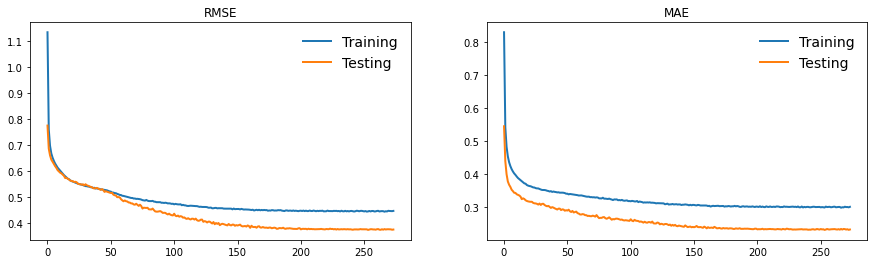

In [16]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 4) )

ax[0].plot( score.history['RMSE'],     linewidth = 2 )
ax[0].plot( score.history['val_RMSE'], linewidth = 2 )
ax[0].legend(['Training', 'Testing'], frameon = False, fontsize = 14)
ax[0].set_title('RMSE');


ax[1].plot( score.history['MAE'],     linewidth = 2 )
ax[1].plot( score.history['val_MAE'], linewidth = 2 )
ax[1].legend(['Training', 'Testing'], frameon = False, fontsize = 14)
ax[1].set_title('MAE');

### Load optimized model

In [17]:
model.load_weights( 'checkpoint/AnomalyDetectionModel.hdf5' )

# Evaluation

## Evaluation on Training data 

In [18]:
# Get predictions
#
pred = model.predict( trainX )


# Calculate Loss (MSE)
#
train_loss = np.mean( np.mean((pred - trainX)**2, axis = 2), axis = 1)


# Create DataFrame with results (loss)
#
Train_Loss = pd.DataFrame( {'Date'  : trainDates,
                            'Loss'  : train_loss,
                           })

Train_Loss.set_index('Date', inplace = True)

In [19]:
# Get predictions
#
pred = model.predict( validX )


# Calculate Loss (MSE)
#
valid_loss = np.mean( np.mean((pred - validX)**2, axis = 2), axis = 1)


# Create DataFrame with results (loss)
#
Valid_Loss = pd.DataFrame( {'Date'   : validDates,
                            'Loss'   : valid_loss,
                           })

Valid_Loss.set_index('Date', inplace = True)

## Define thresholds

In [20]:
# Calculate thresholds
#
WARNING  = np.quantile( Train_Loss['Loss'], 0.95  )
CRITICAL = np.quantile( Train_Loss['Loss'], 0.997 )

logger.info('[INFO] Threshold were calculated')
#
print('[INFO] WARNING  threshold: ', WARNING)
print('[INFO] CRITICAL threshold: ', CRITICAL)

[INFO] Threshold were calculated


[INFO] WARNING  threshold:  0.438669131582596
[INFO] CRITICAL threshold:  1.6819977763347198


## Visualization

### Loss Histogram

/Users/livieris/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/livieris/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


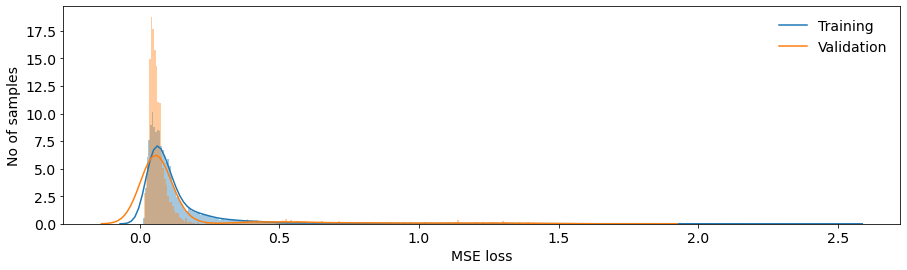

In [21]:
fig, ax = plt.subplots( figsize = (15, 4) )

sns.distplot(Train_Loss['Loss'], bins = 'auto', kde = True, ax = ax)
sns.distplot(Valid_Loss['Loss'], bins = 'auto', kde = True, ax = ax)

plt.legend(['Training', 'Validation'], frameon = False, fontsize = 14)
plt.xticks( size = 14 )
plt.yticks( size = 14 )
plt.xlabel("MSE loss", size=14)
plt.ylabel("No of samples", size=14)
plt.show()

### Plot Train/Valid loss

Number of anomaly samples:  67/22068


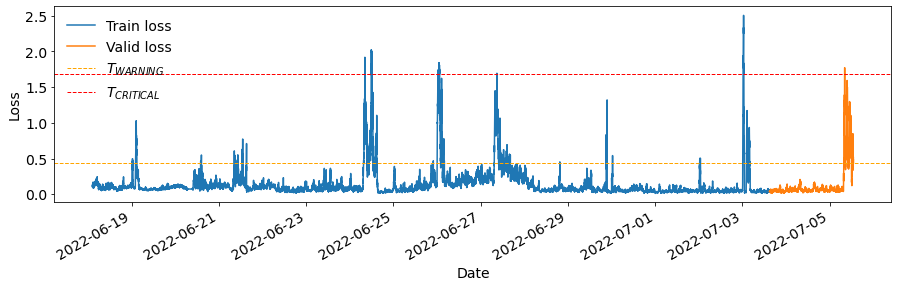

In [22]:
# Detect all the samples which are anomalies
#
anomalies = Train_Loss['Loss'] > CRITICAL
#
Train_Loss['anomaly'] = np.where(anomalies, 'ANOMALY', 'NORMAL')


print("Number of anomaly samples:  {}/{}".format(np.sum(anomalies), len(anomalies)) )


# Plot train-loss
#
ax = Train_Loss.plot( figsize = (15, 4) )
# Plot valid-loss
Valid_Loss.plot(ax = ax)


# Plot thresholds
#
plt.axhline(y=WARNING,  linewidth=1, color='orange', linestyle='--')
plt.axhline(y=CRITICAL, linewidth=1, color='red',    linestyle='--')


plt.xticks(size = 14)
plt.yticks(size = 14)
plt.xlabel("Date", size = 14)
plt.ylabel("Loss", size = 14);
plt.legend(['Train loss', 'Valid loss', '$T_{WARNING}$', '$T_{CRITICAL}$'], frameon = False, fontsize = 14);
plt.show();

## Evaluation of Testing data

In [23]:
# Get predictions
#
pred = model.predict( testX )


# Calculate Loss (MSE)
#
test_loss = np.mean( np.mean((pred - testX)**2, axis = 2), axis = 1)


# Create DataFrame with results (loss)
#
Test_Loss = pd.DataFrame( {'Date' : testDates,
                           'Loss' : test_loss,
                           })


Test_Loss.set_index('Date', inplace=True)

## Visualization

### Loss Histogram

/Users/livieris/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/livieris/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


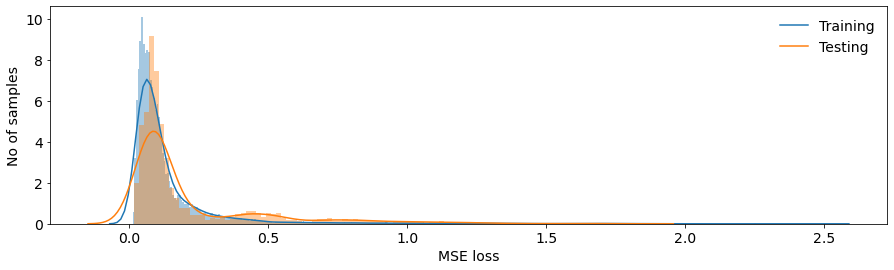

In [24]:
fig, ax = plt.subplots( figsize=(15, 4) )

sns.distplot(Train_Loss['Loss'], bins = 'auto', kde = True, ax = ax)
sns.distplot(Test_Loss['Loss'],  bins = 'auto', kde = True, ax = ax)

plt.legend(['Training', 'Testing'], frameon = False, fontsize = 14)
plt.xticks( size = 14 )
plt.yticks( size = 14 )
plt.xlabel("MSE loss", size = 14)
plt.ylabel("No of samples", size = 14)
plt.show()

### Plot Train/Valid loss

Number of anomaly samples:  2/2763


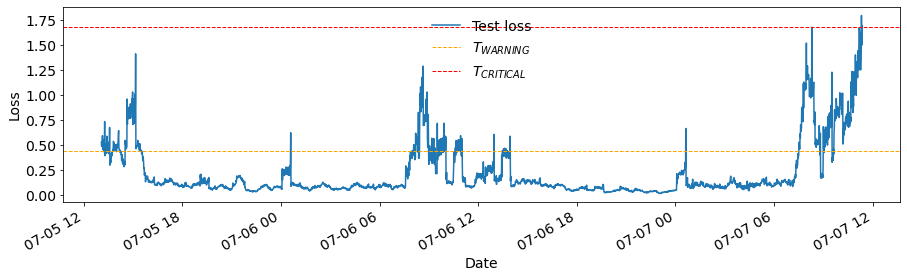

In [25]:
# Detect all the samples which are anomalies
#
anomalies = Test_Loss['Loss'] > CRITICAL
#
Test_Loss['anomaly'] = np.where(anomalies, 'ANOMALY', 'NORMAL')


print("Number of anomaly samples:  {}/{}".format(np.sum(anomalies), len(anomalies)) )


# Plot test-loss
#
ax = Test_Loss.plot( figsize = (15, 4) )


# Plot thresholds
#
plt.axhline(y=WARNING,  linewidth=1, color='orange', linestyle='--')
plt.axhline(y=CRITICAL, linewidth=1, color='red',    linestyle='--')


plt.xticks(size = 14)
plt.yticks(size = 14)
plt.xlabel("Date", size = 14)
plt.ylabel("Loss", size = 14);
plt.legend(['Test loss', '$T_{WARNING}$', '$T_{CRITICAL}$'], frameon = False, fontsize = 14);
plt.show();

# Save

In [26]:
# Save model
#
model.save( 'model_repository/AnomalyDetectionModel/1/model.savedmodel')
#
logger.info('[INFO] Anomaly detection model was saved in model_repository')

2022-07-07 16:01:13.938650: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
Function `_wrapped_model` contains input name(s) InputLayer with unsupported characters which will be renamed to inputlayer in the SavedModel.


INFO:tensorflow:Assets written to: model_repository/AnomalyDetectionModel/1/model.savedmodel/assets


Assets written to: model_repository/AnomalyDetectionModel/1/model.savedmodel/assets
[INFO] Anomaly detection model was saved in model_repository


In [27]:
# Save scaler
#
pickle.dump(scaler, open('model_repository/AnomalyDetectionModel/Scaler.pkl', 'wb'))

logger.info('[INFO] Scaler was saved in model_repository')

[INFO] Scaler was saved in model_repository


In [28]:
# Save thresholds
#
import json

Thresholds = {'WARNING':  WARNING,
              'CRITICAL': CRITICAL}

with open('model_repository/AnomalyDetectionModel/Thresholds.json', 'w') as fp:
    json.dump(Thresholds, fp)
#
logger.info('[INFO] Thresholds were saved in model_repository')

[INFO] Thresholds were saved in model_repository
